# Predicting Bike Rentals
Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day.

We'll try to predict the total number of bikes people rented in a given.

### Introduction to DataSet
You can download the data from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

 - The Dataset contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day.

In [1]:
import pandas as pd

bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.head()

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

Here are the descriptions for the relevant columns:

 - instant - A unique sequential ID number for each row
 - dteday - The date of the rentals
 - season - The season in which the rentals occurred
 - yr - The year the rentals occurred
 - mnth - The month the rentals occurred
 - hr - The hour the rentals occurred
 - holiday - Whether or not the day was a holiday
 - weekday - The day of the week (as a number, 0 to 7)
 - workingday - Whether or not the day was a working day
 - weathersit - The weather (as a categorical variable)
 - temp - The temperature, on a 0-1 scale
 - atemp - The adjusted temperature
 - hum - The humidity, on a 0-1 scale
 - windspeed - The wind speed, on a 0-1 scale
 - casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
 - registered - The number of registered riders (people who had already signed up)
 - cnt - The total number of bike rentals (casual + registered)
 
We'll predict the **cnt** column using all of the other columns, except for casual and registered.

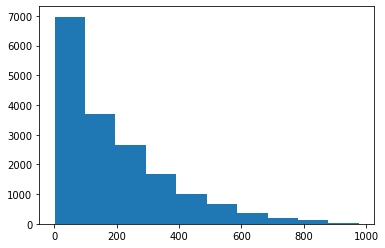

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(bike_rentals['cnt'])
plt.show()

bike_rentals.corr()['cnt']

### Calculating Features
The **hr** column in bike_rentals contains the hours during which bikes are rented, from 1 to 24.

We can introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This will bundle similar times together, enabling the model to make better decisions.



In [5]:
def assign_labels(row):
    if(6<= row <12):
        return(1)
    elif(12 <= row <18):
        return(2)
    elif(18<= row <24):
        return(3)
    else:
        return(4)
    
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_labels)
print(bike_rentals['time_label'].value_counts())

2    4375
3    4368
1    4360
4    4276
Name: time_label, dtype: int64


### Splitting the Data Into Train and Test Sets

### Error Metric
The **mean squared error** metric makes the most sense to evaluate our error. MSE works on continuous numeric data, which fits our data quite well.

In [6]:
#Splitting data in train and Test
train = bike_rentals.sample(frac = 0.8, random_state=1)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

## Applying Linear Regression

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

predictor = list(train.columns)
predictor.remove('cnt')
predictor.remove('casual')
predictor.remove('dteday')
predictor.remove('registered')

lr = LinearRegression()
lr.fit(train[predictor], train['cnt'])
train_predictions = lr.predict(train[predictor])
test_predictions = lr.predict(test[predictor])
train_mse = mean_squared_error(train['cnt'], train_predictions)
test_mse = mean_squared_error(test['cnt'], test_predictions)

print("MSE for train dataset is:" , train_mse)
print("MSE for test dataset is:" , test_mse)

MSE for train dataset is: 17584.747420833708
MSE for test dataset is: 17052.12487124757


The error is very high, which may be due to the fact that the data has a few extremely high rental counts, but otherwise mostly low counts. Larger errors are penalized more with MSE, which leads to a higher total error.

### Applying Decision Trees

In [9]:
from sklearn.tree import DecisionTreeRegressor

for samples_leaf in [5,6,7,8,9,10,20]:
    dt = DecisionTreeRegressor(min_samples_leaf=samples_leaf, random_state=1)
    dt.fit(train[predictor], train['cnt'])
    test_predictions = dt.predict(test[predictor])
    test_mse = mean_squared_error(test['cnt'], test_predictions)
    print('MSE for test dataset with min_samples_leaf:',samples_leaf, 'is:', test_mse)

MSE for test dataset with min_samples_leaf: 5 is: 2742.890284482682
MSE for test dataset with min_samples_leaf: 6 is: 2643.6843954529204
MSE for test dataset with min_samples_leaf: 7 is: 2586.8105573048556
MSE for test dataset with min_samples_leaf: 8 is: 2661.0344637726353
MSE for test dataset with min_samples_leaf: 9 is: 2686.9232491150765
MSE for test dataset with min_samples_leaf: 10 is: 2700.5468333375275
MSE for test dataset with min_samples_leaf: 20 is: 3156.280964486221


Minimumn MSE is : 2586.8105573 for min_samples_leaf: 7

By taking the nonlinear predictors into account, the decision tree regressor appears to have much higher accuracy than linear regression.

### Applying Random Forests

In [12]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
from sklearn.ensemble import RandomForestRegressor

for samples_leaf in [1,2,3,4,5,6,10,20]:
    rf = RandomForestRegressor(min_samples_leaf=samples_leaf, random_state=2)
    rf.fit(train[predictor], train['cnt'])
    test_predictions = rf.predict(test[predictor])
    test_mse = mean_squared_error(test['cnt'], test_predictions)
    print('MSE for test dataset with min_sample_leaf:', samples_leaf, 'is', test_mse)

MSE for test dataset with min_sample_leaf: 1 is 2124.9600632911392
MSE for test dataset with min_sample_leaf: 2 is 2051.3894183948355
MSE for test dataset with min_sample_leaf: 3 is 2100.364730059405
MSE for test dataset with min_sample_leaf: 4 is 2163.1750495672745
MSE for test dataset with min_sample_leaf: 5 is 2204.931811464042
MSE for test dataset with min_sample_leaf: 6 is 2257.104181369704
MSE for test dataset with min_sample_leaf: 10 is 2470.700221428935
MSE for test dataset with min_sample_leaf: 20 is 2936.29722516597


Minimumn MSE is : **2051.389418** for min_samples_leaf: 2

By removing some of the sources of overfitting, the random forest accuracy is improved over the decision tree accuracy.